# Road segmentation

In [1]:
%matplotlib inline

import numpy as np
import os,sys

from sklearn import linear_model
from sklearn import neighbors
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow import keras

from helpers import *
from plots import *
import postprocessing

%load_ext autoreload
%autoreload 2

C:\Users\hutte\Anaconda3\envs\ada\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hutte\Anaconda3\envs\ada\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hutte\Anaconda3\envs\ada\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hutte\Anaconda3\envs\ada\lib\site-packages\tensorflow\python\framework

## Parameters

In [ ]:
# Model and hyper-parameters grid.

#model = linear_model.LogisticRegression(class_weight="balanced", solver="lbfgs")
#param_grid = {'C': [1e5, 1e4, 1e3, 1e2, 1e1, 1, 1e-1, 1e-2, 1e-3, 1e-4]}

model = neighbors.KNeighborsClassifier(algorithm='auto')
param_grid = {'n_neighbors': [1, 5, 9, 13, 17, 21, 25, 29, 33, 37], 'weights': ['uniform', 'distance']}
#param_grid = {'n_neighbors': [15, 25, 35, 45, 55, 65, 75, 85, 95], 'weights': ['distance']}

#model = neighbors.RadiusNeighborsClassifier(algorithm='auto')
#param_grid = {'radius': [0.11, 0.12, 0.13, 0.14], 'weights': ['uniform', 'distance'], 'outlier_label': [0, 1]}

#model = svm.SVC(random_state=0)
#param_grid = {'C': [1.0], 'kernel': ['rbf'], 'class_weight': [None]}

#model = svm.LinearSVC(random_state=0)
#param_grid = {'C': [10000000000000], 'class_weight': [None], 'max_iter': [10000]}

In [2]:
# Number of training images
n = 100

# Number of folds for the cross-validation.
k = 3

# Fix randomness (integer) or not (None)
seed = 0

# AIcrowd expects patches of 16 by 16 pixels.
patch_size = 16
aggregate_threshold = 0.3

# Percentage of pixels > 1 required to assign a foreground label to a patch (default=0.25)
# We can give multiple values as a list, and it will keep the one that yields the best F1 score on cross-validation.
foreground_threshold = [0.25]

# Extraction function
#extraction_func = extract_features_2d
extraction_func = extract_features_6d
#extraction_func = extract_features_12d

# Preprocessing function
#preproc = None
preproc = preprocessing.StandardScaler()
#preproc = preprocessing.Normalizer()

# Create a submission file ?
submit = False

## Data extraction

In [3]:
# Load a set of images
imgs, gt_imgs = load_training_images(n)

In [4]:
# Extract patches from all images
img_patches = get_patches(imgs, patch_size)
gt_patches = get_patches(gt_imgs, patch_size)

In [5]:
# Get features for each image patch
X = get_features_from_patches(img_patches, extraction_func)
Ys = [get_labels_from_patches(gt_patches, t) for t in foreground_threshold]
Y = None
print(X.shape)

(62500, 6)


In [6]:
# Preprocessing
if preproc is not None:
    preproc = preproc.fit(X)
    X = preproc.transform(X)
print(X)

[[-1.0148102  -1.0572761  -0.9564702  -0.19662268 -0.24969415 -0.30616102]
 [-1.0724914  -0.90638685 -0.8678197  -0.36098725 -0.3208127  -0.2463872 ]
 [-0.10896936  0.04511511  0.11186031  0.43051064  0.35006282  0.5703745 ]
 ...
 [-0.16487242 -0.22509801 -0.11024366 -0.891969   -0.8374671  -0.79912746]
 [ 0.19080554  0.08509734  0.14097874 -0.45032263 -0.4293388  -0.44673806]
 [ 0.3525976   0.21915239  0.26872662  0.17099139  0.21140355  0.11306535]]


## Cross-validation and parameters tuning

In [ ]:
split = StratifiedShuffleSplit(n_splits=k, random_state=seed)
search = GridSearchCV(model, param_grid, cv=split, scoring="f1")
score = -1
# Cross-validate with different foreground_threshold values.
for i, y in enumerate(Ys):
    # Grid search on the parameters, to find the best score.
    search.fit(X,y)
    print("Threshold={} : score={}".format(foreground_threshold[i], search.best_score_))
    if search.best_score_ > score:
        Y = y
        score = search.best_score_
        model = search.best_estimator_

In [ ]:
print("F1 score:", score)
print(model.get_params())

## Neural Network

In [7]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


In [35]:
# Model
# Neural network, using keras library. We chose this library as it has a user-friendly high-level API which makes it easy to try different NN models
model = keras.Sequential([
        keras.layers.Dense(32, input_dim=len(X[0])),
        keras.layers.Activation("relu"),
        keras.layers.Dense(32),
        keras.layers.Activation("relu"),
        keras.layers.Dense(128),
        keras.layers.Activation("relu"),
        keras.layers.Dense(128),
        keras.layers.Activation("relu"),
        keras.layers.Dense(32),
        keras.layers.Activation("relu"),
        keras.layers.Dense(1, activation='sigmoid')
    ])

# Use the adam optimizer
adam = keras.optimizers.Adam(lr=0.01)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[f1_m])

# Training
model.fit(X, Ys[0], epochs=20, validation_split=0.1)

Train on 56250 samples, validate on 6250 samples
Epoch 1/20
56250/56250 [==============================] - 6s 112us/sample - loss: 0.1533 - f1_m: 0.3997 - val_loss: 0.1416 - val_f1_m: 0.5498
Epoch 2/20
56250/56250 [==============================] - 5s 93us/sample - loss: 0.1449 - f1_m: 0.4742 - val_loss: 0.1406 - val_f1_m: 0.5154
Epoch 3/20
56250/56250 [==============================] - 5s 93us/sample - loss: 0.1431 - f1_m: 0.4831 - val_loss: 0.1444 - val_f1_m: 0.5858
Epoch 4/20
56250/56250 [==============================] - 5s 92us/sample - loss: 0.1420 - f1_m: 0.4912 - val_loss: 0.1367 - val_f1_m: 0.6240
Epoch 5/20
56250/56250 [==============================] - 5s 93us/sample - loss: 0.1410 - f1_m: 0.5029 - val_loss: 0.1363 - val_f1_m: 0.5650
Epoch 6/20
56250/56250 [==============================] - 5s 93us/sample - loss: 0.1406 - f1_m: 0.5075 - val_loss: 0.1364 - val_f1_m: 0.6038
Epoch 7/20
56250/56250 [==============================] - 5s 95us/sample - loss: 0.1403 - f1_m: 0.5055 -

In [ ]:
Z = model.predict(X)
Z = [1 if t >= 0.25 else 0 for t in Z]

## Predictions

In [ ]:
# Predict on the training set
Z = model.predict(X)

TPR = true_positive_rate(Z, Y)
TNR = true_negative_rate(Z, Y)
FPR = false_positive_rate(Z, Y)
FNR = false_negative_rate(Z, Y)
print('True positive rate = ' + str(TPR))
print('True negative rate = ' + str(TNR))
print('False positive rate = ' + str(FPR))
print('False negative rate = ' + str(FNR))

In [ ]:
# Predict on test set and create submission
if submit:
    create_submission(model, extraction_func, patch_size, preproc, aggregate_threshold)

## Comparison of groundtruth and prediction

In [28]:
idx = 1
img = imgs[idx]
gt_img = gt_imgs[idx]
# Run predictions
Xi = get_features_from_img(img, extraction_func, patch_size)
Yi = get_labels_from_img(gt_img, foreground_threshold, patch_size)
if preproc is not None:
    Xi = preproc.transform(Xi)
Zi = model.predict(Xi)

In [29]:
Zi[:30]

array([[0.11108696],
       [0.10992831],
       [0.22915635],
       [0.18168193],
       [0.08814007],
       [0.10528237],
       [0.40934098],
       [0.3237591 ],
       [0.20282045],
       [0.3131974 ],
       [0.65435535],
       [0.44033223],
       [0.74091226],
       [0.36378324],
       [0.3960061 ],
       [0.01866788],
       [0.12021679],
       [0.24370259],
       [0.51688516],
       [0.16834307],
       [0.15294519],
       [0.35169202],
       [0.20233181],
       [0.49052617],
       [0.0709933 ],
       [0.12215522],
       [0.05282447],
       [0.03868514],
       [0.08549634],
       [0.10659674]], dtype=float32)

In [30]:
Zi = [1 if t >= 0.40 else 0 for t in Zi]
Zi[:30]

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0]

In [31]:
w = img.shape[0]
h = img.shape[1]
label_img = label_to_img(w, h, patch_size, patch_size, Yi)
predicted_img = label_to_img(w, h, patch_size, patch_size, Zi)

Groundtruth:


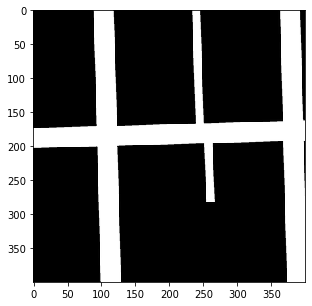

In [32]:
print("Groundtruth:")
show_img(gt_imgs[idx])

Patched groundtruth:


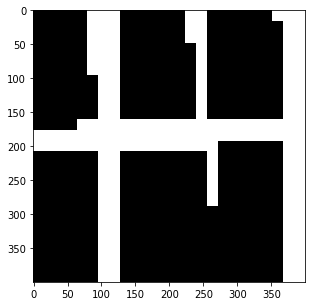

In [33]:
print("Patched groundtruth:")
show_img(label_img)

Predictions:


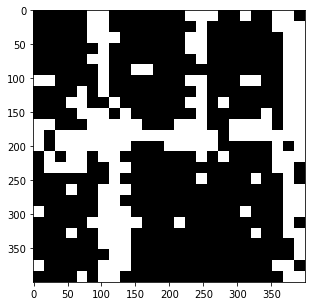

In [34]:
print("Predictions:")
show_img(predicted_img)

## Visualization of a single test image

In [23]:
# Load a test image
img_idx = 1

img_path = "Datasets/test_set_images/test_{0}/test_{0}.png".format(img_idx)
img = load_image(img_path)

In [24]:
# Run predictions
Xi = get_features_from_img(img, extraction_func, patch_size)
if preproc is not None:
    Xi = preproc.transform(Xi)
Zi = model.predict(Xi)

In [25]:
# threshold for labels 0 or 1
Zi = [1 if t >= 0.45 else 0 for t in Zi]

In [26]:
if Xi.shape[1] == 2:
    show_data_points(Xi, Zi)

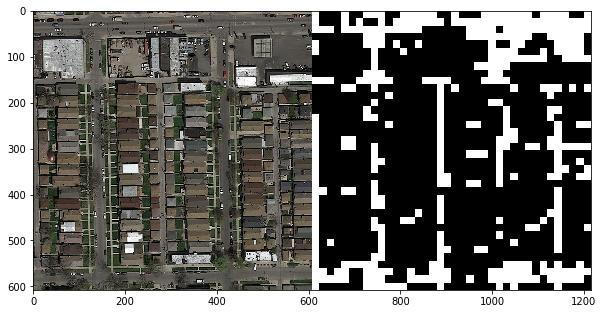

In [27]:
# Display prediction as an image
w = img.shape[0]
h = img.shape[1]
predicted_img = label_to_img(w, h, patch_size, patch_size, Zi)
show_img_concatenated(img, predicted_img)

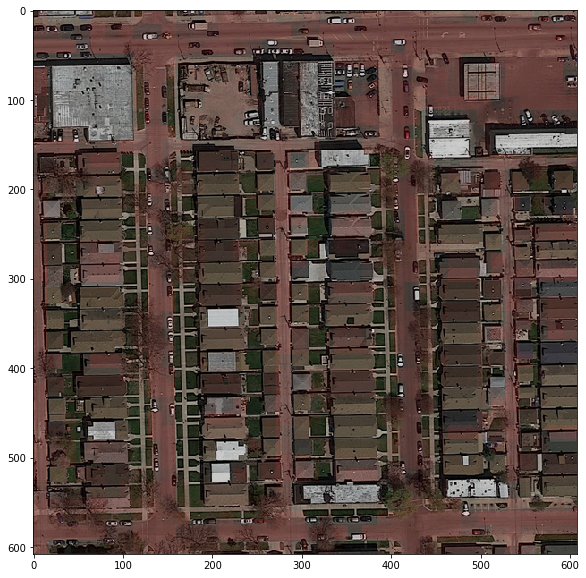

In [109]:
show_img_overlay(img, predicted_img)

In [ ]:
if patch_size != 16:
    Zi_agg = postprocessing.aggregate_labels(Zi, patch_size, 16, aggregate_threshold)
    predicted_img_agg = label_to_img(w, h, 16, 16, Zi_agg)
    show_img(predicted_img_agg)
    show_img_overlay(img, predicted_img_agg)

In [ ]:
postprocessing.hough_transform(predicted_img)